<a href="https://colab.research.google.com/github/SunkaraboinaPraveenKumar/Machine_Learning_Projects/blob/main/Poem_Sentiment_Distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
from transformers import pipeline
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nturl2path
import torch
import torch.nn.functional as F

In [15]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.2 MB/s eta 0:00:00


In [16]:
from datasets import load_dataset
dataset=load_dataset("poem_sentiment")
dataset

README.md:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.34k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/6.16k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/892 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/105 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/104 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 104
    })
})

In [17]:
train_ds=dataset['train']
train_ds

Dataset({
    features: ['id', 'verse_text', 'label'],
    num_rows: 892
})

In [18]:
label_names=train_ds.features['label'].names
label_names

['negative', 'positive', 'no_impact', 'mixed']

In [19]:
print(len(train_ds))
train_ds[0]

892


{'id': 0,
 'verse_text': 'with pale blue berries. in these peaceful shades--',
 'label': 1}

In [20]:
train_ds.column_names

['id', 'verse_text', 'label']

In [21]:
train_ds.features

{'id': Value(dtype='int32', id=None),
 'verse_text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive', 'no_impact', 'mixed'], id=None)}

In [22]:
train_ds[:2]

{'id': [0, 1],
 'verse_text': ['with pale blue berries. in these peaceful shades--',
  'it flows so long as falls the rain,'],
 'label': [1, 2]}

In [23]:
train_ds['verse_text'][:2]

['with pale blue berries. in these peaceful shades--',
 'it flows so long as falls the rain,']

In [24]:
train=pd.DataFrame(dataset['train'])

In [25]:
train.head()

,id,verse_text,label
0,0,with pale blue berries. in these peaceful shad...,1
1,1,"it flows so long as falls the rain,",2
2,2,"and that is why, the lonesome day,",0
3,3,"when i peruse the conquered fame of heroes, an...",3
4,4,of inward strife for truth and liberty.,3


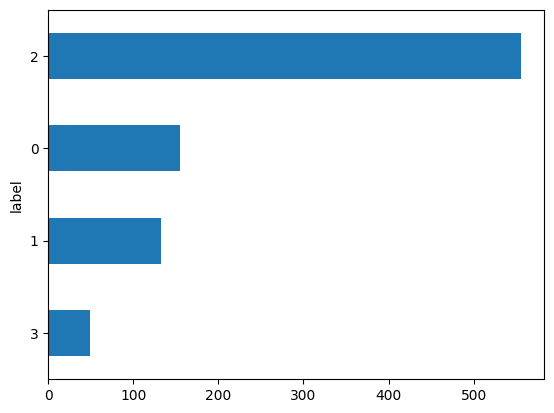

In [26]:
train['label'].value_counts(ascending=True).plot.barh()
plt.show()

In [27]:
#Tokenize
from transformers import AutoTokenizer
model_ckpt='distilbert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [28]:
# from transformers import DistilBertTokenizer
# distilbert_tokenizer=DistilBertTokenizer.from_pretrained(model_ckpt)

In [29]:
print('tokenizer vocab size:',tokenizer.vocab_size)
print('tokenizer word to index:',tokenizer.model_max_length)
print('feature name:',tokenizer.model_input_names)

tokenizer vocab size: 30522
tokenizer word to index: 512
feature name: ['input_ids', 'attention_mask']


In [30]:
def tokenize(batch):
  return tokenizer(batch['verse_text'],truncation=True,padding=True)

# padding is done to token size less than max token size in batch
# truncation is done to token size greater than max token size in batch

In [31]:
print(tokenize(train_ds[:2]))
# Attention mask allows model to ignore additional padded parts tokens
# it has same size as input_ids if attention_mask has 1 transfomers considers that


{'input_ids': [[101, 2007, 5122, 2630, 22681, 1012, 1999, 2122, 9379, 13178, 1011, 1011, 102], [101, 2009, 6223, 2061, 2146, 2004, 4212, 1996, 4542, 1010, 102, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]}


In [32]:
ds_pretrained_features_encoded=dataset.map(tokenize,batched=True,batch_size=None)

Map:   0%|          | 0/892 [00:00<?, ? examples/s]

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

In [33]:
print('Features names of Dataset',ds_pretrained_features_encoded['train'].column_names)

Features names of Dataset ['id', 'verse_text', 'label', 'input_ids', 'attention_mask']


In [34]:
from transformers import AutoModel
model_ckpt='distilbert-base-uncased'
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [35]:
def get_hidden_state(batch):
  inputs={k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

  with torch.no_grad():
    last_hidden_state=model(**inputs).last_hidden_state

  return {'hidden_state':last_hidden_state[:,0].cpu().numpy()}

ds_pretrained_features_encoded.set_format('torch',columns=['input_ids','attention_mask','label'])
pretrained_hidden_states=ds_pretrained_features_encoded.map(get_hidden_state,batched=True)
pretrained_hidden_states['train'].column_names

Map:   0%|          | 0/892 [00:00<?, ? examples/s]

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

['id', 'verse_text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [36]:
import numpy as np

In [37]:
X_train=np.array(pretrained_hidden_states['train']['hidden_state'])
X_valid=np.array(pretrained_hidden_states['validation']['hidden_state'])
Y_train=np.array(pretrained_hidden_states['train']['label'])
Y_valid=np.array(pretrained_hidden_states['validation']['label'])

In [38]:
!pip install umap-learn

In [39]:
# use of umap-learn for visualize through dimensionality reduction
import umap
from sklearn.preprocessing import MinMaxScaler
X_trained_scaled=MinMaxScaler().fit_transform(X_train)
mapper=umap.UMAP(n_components=2,metric='cosine').fit(X_trained_scaled)

In [41]:
df_embedded_from_hidden=pd.DataFrame(mapper.embedding_,columns=['X','Y'])
df_embedded_from_hidden['label']=Y_train
df_embedded_from_hidden.head()

,X,Y,label
0,10.433463,3.488697,1
1,6.648274,6.240750,2
2,7.029768,3.240427,0
3,5.722896,6.193919,3
4,8.854662,4.385395,3


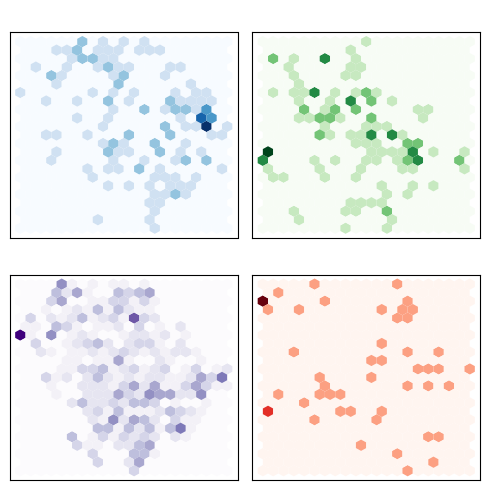

In [45]:
fig,axes =plt.subplots(2,2,figsize=(5,5))

axes=axes.flatten()

#Colors used
cmaps=['Blues','Greens','Purples','Reds','Greys','Oranges']
labels=dataset['train'].features['label'].names
for i,(label,cmap) in enumerate(zip(labels,cmaps)):
  df_embedding_subplot=df_embedded_from_hidden.query(f'label=={i}')
  axes[i].hexbin(df_embedding_subplot['X'],df_embedding_subplot['Y'],cmap=cmap,gridsize=20,linewidth=(0,))
  axes[i].set_title(label,color='white')
  axes[i].set_xticks([])
  axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [46]:
# Training a Simple Logistic classifier

In [47]:
from sklearn.linear_model import LogisticRegression
lr_clf=LogisticRegression(max_iter=3000)
lr_clf.fit(X_train,Y_train)
print('Logistic Regression Score,',lr_clf.score(X_valid,Y_valid))

Logistic Regression Score, 0.780952380952381


In [48]:
### Compare Result with Dummy classifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
dummy_clf=DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train,Y_train)
print(dummy_clf.score(X_valid,Y_valid))

0.6571428571428571


In [65]:
# Fine Tuning Distilbert
from transformers import AutoModelForSequenceClassification
num_labels=len(dataset['train'].features['label'].names)
model=(AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=num_labels).to(device))

from sklearn.metrics import accuracy_score,f1_score
def compute_metrics(pred):
    labels=pred.label_ids
    preds=pred.predictions.argmax(-1)
    f1=f1_score(labels,preds,average='weighted',zero_division=0)
    accuracy=accuracy_score(labels,preds)
    return {'f1':f1,'accuracy':accuracy}


In [66]:
from transformers import Trainer, TrainingArguments
batch_size=12
logging_steps=len(ds_pretrained_features_encoded['train'])//batch_size
model_name=f"{model_ckpt}-finetune-poem"

training_args=TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [67]:
import os
os.environ["WANDB_DISABLED"] = "false"

In [68]:
trainer=Trainer(model=model,args=training_args,
                compute_metrics=compute_metrics,
                train_dataset=ds_pretrained_features_encoded["train"],
                eval_dataset=ds_pretrained_features_encoded["validation"],
                tokenizer=tokenizer
                )
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.020100,0.752763,0.521182,0.657143
2,0.718000,0.581963,0.817942,0.838095


TrainOutput(global_step=150, training_loss=0.8665988119443258, metrics={'train_runtime': 379.5825, 'train_samples_per_second': 4.7, 'train_steps_per_second': 0.395, 'total_flos': 12924311538432.0, 'train_loss': 0.8665988119443258, 'epoch': 2.0})

In [74]:
preds_output = trainer.predict(ds_pretrained_features_encoded['validation'])
preds_output.metrics

{'test_loss': 0.5819628238677979,
 'test_f1': 0.8179419136075483,
 'test_accuracy': 0.8380952380952381,
 'test_runtime': 8.3547,
 'test_samples_per_second': 12.568,
 'test_steps_per_second': 1.077}

In [77]:
# Error Analysis
from torch.nn.functional import cross_entropy

def forward_pass_with_loss_and_label(batch):
  inputs={k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

  with torch.no_grad():
    output=model(**inputs)
    pred_label=torch.argmax(output.logits,axis=-1)
    loss=cross_entropy(output.logits,batch['label'].to(device),reduction='none')

  return {
    'loss': loss.cpu().numpy(),
    'predicted_labels': pred_label.cpu().numpy()
}


In [78]:
ds_pretrained_features_encoded.set_format('torch',columns=['input_ids','attention_mask','label'])
ds_pretrained_features_encoded['validation']=ds_pretrained_features_encoded['validation'].map(forward_pass_with_loss_and_label,batch_size=16,batched=True)


Map:   0%|          | 0/105 [00:00<?, ? examples/s]

In [83]:
def label_int2str(row):
  return dataset['train'].features['label'].int2str(row)

ds_pretrained_features_encoded.set_format('pandas')
cols=['verse_text','label','predicted_labels','loss']
df_test=ds_pretrained_features_encoded['validation'][:][cols]
df_test['label']=df_test['label'].apply(label_int2str)
df_test['predicted_labels']=(df_test['predicted_labels'].apply(label_int2str))
df_test.sort_values('loss',ascending=False).head(10)

,verse_text,label,predicted_labels,loss
63,on us lift up the light,positive,no_impact,3.011541
6,"taking and giving radiance, and the slopes",positive,no_impact,2.768555
66,i kin eat in peace.,positive,no_impact,2.748864
41,alone went the fair-armed gudrun to her flower...,positive,no_impact,2.721181
67,"in yonder green meadow, to memory dear,",positive,no_impact,2.192334
5,"when the brow is cold as the marble stone,",negative,no_impact,2.129131
80,strong tarchon snatch’d and bore away his prize.,positive,no_impact,2.104028
52,"nor can express the love it knew,",negative,no_impact,1.930893
73,willis sneered:,negative,no_impact,1.748850
1,"shall yet be glad for him, and he shall bless",positive,no_impact,1.739758


In [85]:
df_test.sort_values('loss',ascending=True).head(10)

,verse_text,label,predicted_labels,loss
45,"and i greet from far the ray,",no_impact,no_impact,0.112844
37,"why write i still all one, ever the same,",no_impact,no_impact,0.116052
49,"no, truly.--i will see her; tell my tale,",no_impact,no_impact,0.116279
54,"might, looking up, see dian dip",no_impact,no_impact,0.117499
39,"soon ez she gits out o' sight,",no_impact,no_impact,0.118840
81,"under the self-same bough, and heard as there",no_impact,no_impact,0.121358
74,"from the bed of minnehaha,",no_impact,no_impact,0.123118
15,from his lady's white hand caught;,no_impact,no_impact,0.123728
33,that in their holes abed at close of day,no_impact,no_impact,0.124520
26,"stood and watched it at the doorway,",no_impact,no_impact,0.124968
